## Building a better model

Following the baseline model and some feature engineering, we will now build a better predictive model. This will follow a few new patterns:
1. We will import data cleaning and feature engineering stuff from external Python modules we've built (for standardization across our machines).
2. We will cross-validate across time: that is, the model will be trained on earlier years and tested on later years.
3. Rather than looping through models (and perhaps working mroe with Pipeline and GridSearch), we will focus on tuning the parameters of the best-performing model from the baseline set.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import sklearn
import sqlite3
import matplotlib

import numpy as np
import pandas as pd
import enchant as en
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split, cross_val_score

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
%aimport data
from data import make_dataset as md

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['legend.markerscale'] = 3
matplotlib.rcParams['font.size'] = 16.0

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data: Preparing for the model

#### Importing the raw data

In [2]:
DIR = os.getcwd() + "/../data/"
t = pd.read_csv(DIR + 'raw/lending-club-loan-data/loan.csv', low_memory=False)
t.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Cleaning, imputing missing values, feature engineering (some NLP)

In [ ]:
t2 = md.clean_data(t)
t3 = md.impute_missing(t2)
# df = md.spelling_mistakes(t3) - skipping for now, so computationally expensive!

Now cleaning data.
Now imputing missing values.


/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:2824: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [8]:
t3.to_csv('{}/../data/processed/2016.12.11_missing_imputed.csv'.format(os.getcwd()))

## Train, test split: Splitting on 2015

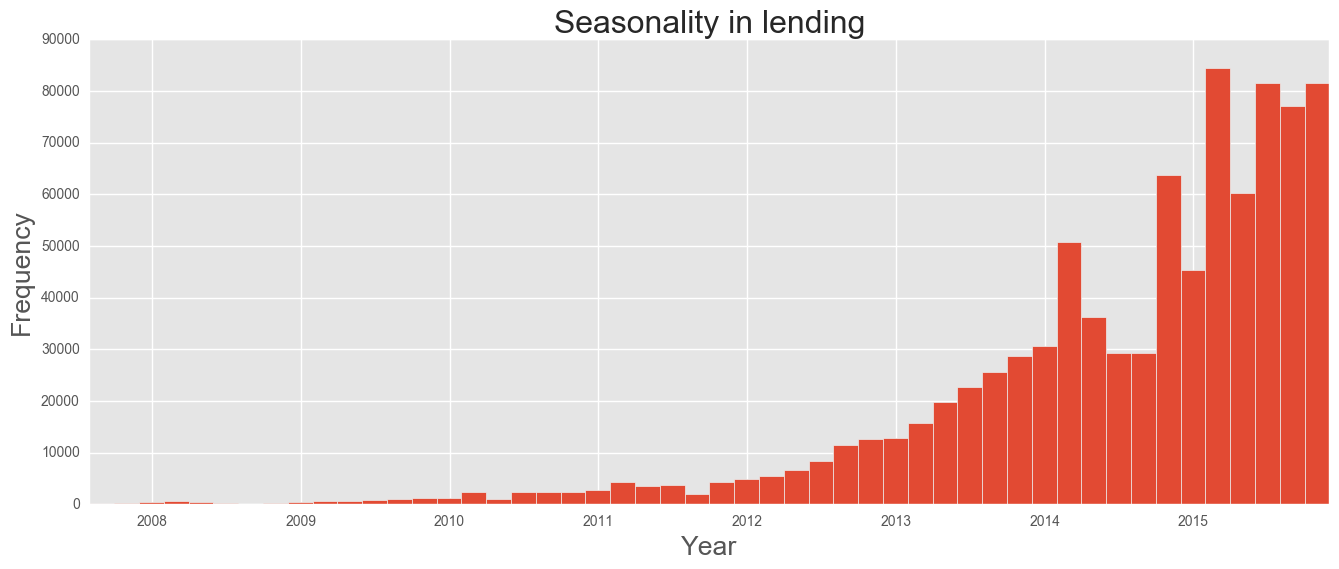

In [41]:
df['issue_d'].hist(bins = 50)
plt.title('Seasonality in lending')
plt.ylabel('Frequency')
plt.xlabel('Year')
plt.show()

We can use past years as predictors of future years. One challenge with this approach is that we confound time-sensitive trends (for example, global economic shocks to interest rates - such as the financial crisis of 2008, or the growth of Lending Club to broader and broader markets of debtors) with differences related to time-insensitive factors (such as a debtor's riskiness).

To account for this, we can bundle our training and test sets into the following blocks:
- Before 2015: Training set
- 2015 to current: Test set

In [44]:
old = df[df['issue_d'] < '2015']
new = df[df['issue_d'] >= '2015']
old.shape, new.shape

((464943, 83), (419823, 83))

We'll use the pre-2015 data on interest rates (`old`) to fit a model and cross-validate it. We'll then use the post-2015 data as a 'wild' dataset to test against.

## Fitting the model

In [54]:
X = old.drop(['emp_title', 'title', 'int_rate'], 1)
y = old['int_rate']
X.shape, y.shape

((464943, 80), (464943,))

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
rfr = RandomForestRegressor(n_estimators = 10, max_features='sqrt')
scores = cross_val_score(rfr, X, y, cv=3)
print("Accuracy: {:.2f} (+/- {:.2f})" % (scores.mean(), scores.std() * 2))

TypeError: float() argument must be a string or a number